In [1]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

image_dir = "./images"
label_dir = "./labels"

images = glob(os.path.join(image_dir, '*.png'))
labels = glob(os.path.join(label_dir, '*.png'))

In [2]:
tags = {0:None, 
        1:"Buildings", 
        2:"Fences",
        3:"Other",
        4:"Pedestrians",
        5:"Poles",
        6:"RoadLines",
        7:"Roads",
        8:"Sidewalks",
        9:"Vegetation",
        10:"Vehicles",
        11:"Walls",
        12:"TrafficSigns"}

total_images = len(images)
total_labels = len(labels)
print("Total images:", total_images)
print("Total labels:", total_labels)

Total images: 1000
Total labels: 1000


In [3]:
# creating data object
d = {'image':images, 'label':labels}
columns = ['image', 'label']
data = pd.DataFrame(d, columns=columns)

Since the training dataset contains hood pixels, we have to get rid of them. 
But the test dataset with same resilution will not contain hood pixels.
My solution is:
- crop the images in test dataset by cutting 100 bottom pixels 
- resize the obtained image so the dimentions can be scaled to the initial size (i.e. since the height loses 100 pixels it becomes 5/6 of the initial number. So the width must become 800*5/6 = 666)
- during training perform scaling and shifting augmentation.  

In [4]:
# getting rid of the bottom pixels and resize images and labels.

def get_image_and_labels(sample, shape=(666,500)):
    image = cv2.imread(sample['image'])
    label = cv2.imread(sample['label'])[:,:,2]
    image = image[:500,:,:]
    label = label[:500,:]
    
    # get label for road pixels (road and lane lines must be the same label)
    label[label == 6] = 7
    label_road = np.zeros_like(label)
    label_road[label == 7] = 1
    
    # get label for car pixels
    label_car = np.zeros_like(label)
    label_car[label == 10] = 1
    
    # resizing
    image = cv2.resize(image, shape, interpolation = cv2.INTER_CUBIC)
    label_car = cv2.resize(label_car, shape, interpolation = cv2.INTER_CUBIC)
    label_road = cv2.resize(label_road, shape, interpolation = cv2.INTER_CUBIC)
    return image, label_car, label_road

def get_real_labels(sample):
    label = cv2.imread(sample['label'])[:,:,2]
    label[label == 6] = 7
    label_road = np.zeros_like(label)
    label_road[label == 7] = 1
    label_car = np.zeros_like(label)
    label_car[label == 10] = 1
    return label_car, label_road

Let's see if we aren't losing anything after applying the transformations.

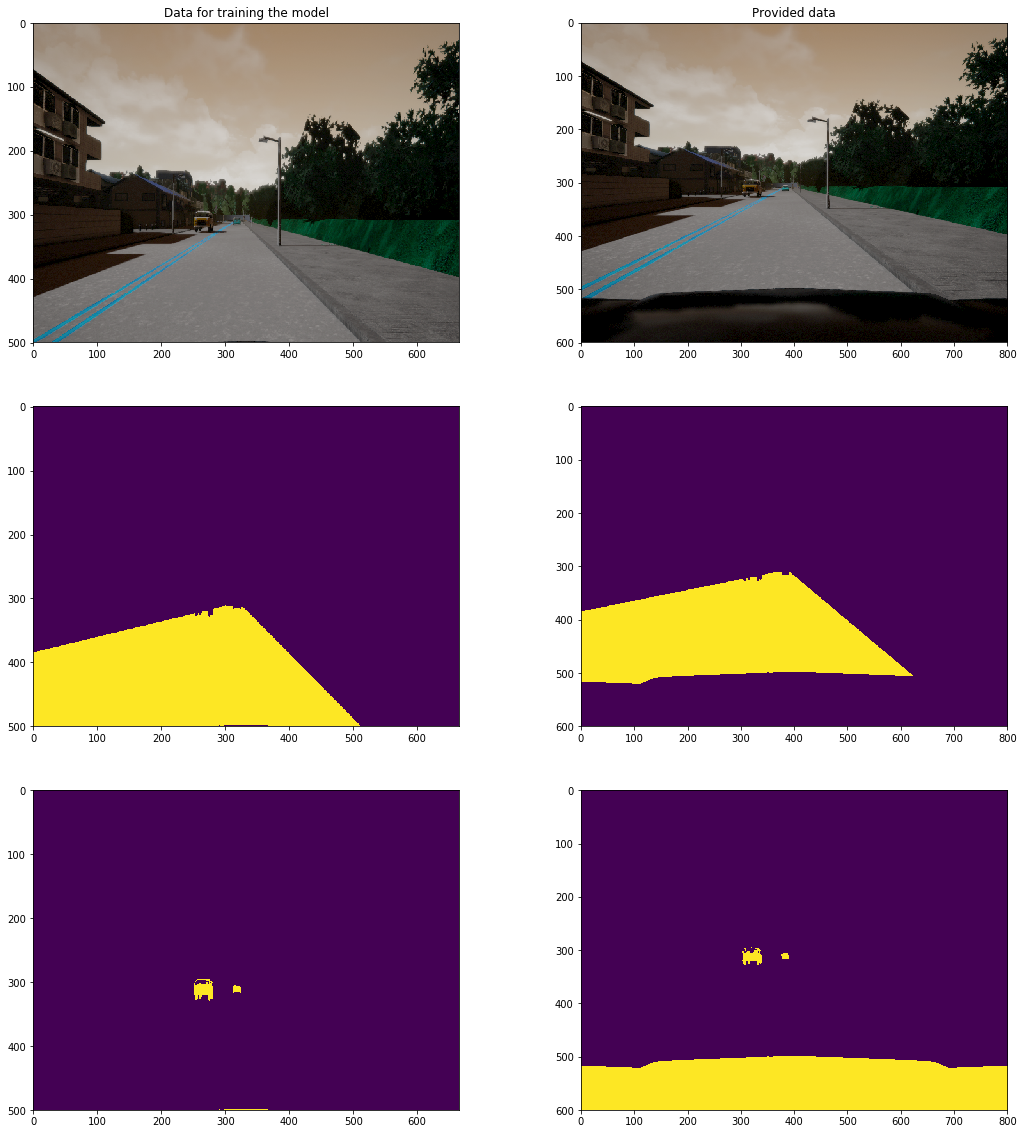

In [5]:
sample = data.iloc[2]
dataset_image = cv2.imread(sample['image'])
train_image, label_car, label_road = get_image_and_labels(sample)

lb_car, lb_road = get_real_labels(sample)

fig, axarr = plt.subplots(3,2,figsize = (18,20))

axarr[0,0].set_title('Data for training the model')
axarr[0,0].imshow(train_image)
axarr[0,1].set_title('Provided data')
axarr[0,1].imshow(dataset_image)

axarr[1,0].imshow(label_road)
axarr[1,1].imshow(lb_road)

axarr[2,0].imshow(label_car)
axarr[2,1].imshow(lb_car)

It seems like the sky now takes too much space. But it's ok if we'll use shifting augmentation. And the is no need to cut the sky because it can appear in the test dataset.

In [14]:
# functions for data augmentations 

# randomly zoom and shift the image and labels a little bit.

def get_zoomed_images_labels(img, car_label, road_label, scale=0.5):
    
    basic_width = img.shape[1]
    basic_height = img.shape[0]

    scale = scale * np.random.random()
    res_scale = 1 + scale
    zoomed_img = cv2.resize(img,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_CUBIC)
    zoomed_car = cv2.resize(car_label,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_CUBIC)
    zoomed_road = cv2.resize(road_label,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_CUBIC)
    
    # We've got a resized image and labels. Now for the random shifting we need to slice 
    # the area of initial size starting from random position.
    # Since we shall use only 20-30% zoom, we can start from any random position
    # i.e y_start can be all the way from 0 to (zoomed_height - basic_height)
    # and x_start can be all the way from 0 to (zoomed_width - basic_width)

    max_y_start = int(basic_height * scale) 
    max_x_start = int(basic_width * scale)
    
    # random start for x:
    x_rand = np.random.random()
    x_start = int(max_x_start * x_rand)
    
    # random start for y:
    y_rand = np.random.random()
    y_start = int(max_y_start * y_rand)
    
    # now slice the zoomed images:
    zoomed_img = zoomed_img[y_start:y_start+basic_height, x_start:x_start+basic_width]
    zoomed_car = zoomed_car[y_start:y_start+basic_height, x_start:x_start+basic_width]
    zoomed_road = zoomed_road[y_start:y_start+basic_height, x_start:x_start+basic_width]
    
    return zoomed_img, zoomed_car, zoomed_road
    
    return res, scale

for i in range(10000):
    #fig,axarr = plt.subplots(1,4, figsize=(18,6))
    zoomed_image, car_label, road_label = get_zoomed_images_labels(train_image, label_car, label_road)
    #axarr[0].imshow(train_image)
    #axarr[1].imshow(zoomed_image)
    #axarr[2].imshow(car_label)
    #axarr[3].imshow(road_label)
print('123')

123


It works!

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout, BatchNormalization, Conv2DTranspose

# split training and validation data

# I use only 1% of data for testing, actually I only want to visualize the results on few unseen images. 
# Since the test dataset will be different anyway, and the given dataset is not large enough,
# I just want to train the model on more samples and then just look at some new images, so 1% is enough.
# The validation size is still matters so I kept it close to 20%

train_samples, validation_data = train_test_split(data, test_size=0.2) # 80% train, 20% the rest
validation_samples, test_samples = train_test_split(validation_data, test_size=0.1) # 19% validation, 1% test
train_samples = data

im_height = 500
im_width = 666

# define the generator
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            labels = []
            for ind, sample in batch_samples.iterrows():
                # center image
                image, lb_car, lb_road = get_image_and_labels(sample)
                final_label = np.zeros((im_height,im_width,2))
                final_label[:,:,1] = lb_road
                final_label[:,:,0] = lb_car
                final_label = final_label.reshape(im_height*im_width*2,)
                
                # with 50% chance augment the image.
                is_aug = np.random.random()
                if(is_aug > 0.5):
                    zoomed_image, zoomed_car, zoomed_road = get_zoomed_images_labels(image, lb_car, lb_road)
                    zoomed_label = np.zeros((im_height,im_width,2))
                    zoomed_label[:,:,1] = zoomed_road
                    zoomed_label[:,:,0] = zoomed_car
                    zoomed_label = zoomed_label.reshape(im_height*im_width*2,)
                    images.append(zoomed_image)
                    labels.append(zoomed_label)
                else:
                    images.append(image)
                    labels.append(final_label)
                    
                image, final_label, zoomed_image, zoomed_label=None,None,None,None
                lb_car, lb_road, zoomed_car, zoomed_road = None,None,None,None
                
            X_train = np.array(images)
            y_train = np.array(labels)
            images, labels = None, None
            yield shuffle(X_train, y_train)

# define batch size and create the generators
batch_size = 8
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

In [22]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D,Cropping2D
from keras.layers.normalization import BatchNormalization
import json

img_w = im_width
img_h = im_height
n_labels = 2

kernel = 3

encoding_layers = [
    Lambda(lambda x: x / 255.0 - 0.5, input_shape = (img_h, img_w, 3)),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),#, input_shape=( img_h, img_w,3)),
    BatchNormalization(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    ZeroPadding2D(((0,0),(0,1))),
    MaxPooling2D(),

    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    ZeroPadding2D(((1,0),(1,1))),
    MaxPooling2D(),

    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    ZeroPadding2D(((1,0),(0,0))),
    MaxPooling2D(),
    
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

]

model = models.Sequential()
model.encoding_layers = encoding_layers
#model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (400, 800, 3)))
#model.add(Conv2D(64, (kernel,kernel), padding='same', activation = "relu"))
for l in model.encoding_layers:
    model.add(l)

decoding_layers = [

    UpSampling2D(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    
    UpSampling2D(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Cropping2D(((1,0),(0,0))),

    UpSampling2D(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Cropping2D(((1,0),(0,1))),

    UpSampling2D(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Cropping2D(((0,0),(0,1))),

    UpSampling2D(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(n_labels, 1, padding='valid'),
    BatchNormalization(),
    Flatten(),
    Activation('sigmoid')
    
]
model.decoding_layers = decoding_layers
for l in model.decoding_layers:
#for l in decoding_layers:
    model.add(l)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 500, 666, 3)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 500, 666, 12)      336       
_________________________________________________________________
batch_normalization_79 (Batc (None, 500, 666, 12)      48        
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 500, 666, 12)      1308      
_________________________________________________________________
batch_normalization_80 (Batc (None, 500, 666, 12)      48        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 250, 333, 12)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 250, 333, 24)      2616      
__________

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
stats = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=300)


Epoch 1/300
125/125 [==============================] - 68s 545ms/step - loss: 0.5626 - val_loss: 1.5183
Epoch 2/300
125/125 [==============================] - 64s 514ms/step - loss: 0.4902 - val_loss: 3.1937
Epoch 3/300
125/125 [==============================] - 64s 512ms/step - loss: 0.4321 - val_loss: 0.5006
Epoch 4/300
125/125 [==============================] - 64s 512ms/step - loss: 0.3912 - val_loss: 0.4186
Epoch 5/300
125/125 [==============================] - 64s 513ms/step - loss: 0.3597 - val_loss: 0.3690
Epoch 6/300
125/125 [==============================] - 64s 512ms/step - loss: 0.3244 - val_loss: 0.3426
Epoch 7/300
125/125 [==============================] - 64s 514ms/step - loss: 0.2963 - val_loss: 0.2875
Epoch 8/300
125/125 [==============================] - 65s 520ms/step - loss: 0.2722 - val_loss: 0.3459
Epoch 9/300
125/125 [==============================] - 64s 515ms/step - loss: 0.2501 - val_loss: 0.2577
Epoch 10/300
125/125 [==============================] - 64s 512m

125/125 [==============================] - 64s 512ms/step - loss: 0.0128 - val_loss: 0.0301
Epoch 80/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0121 - val_loss: 0.0155
Epoch 81/300
125/125 [==============================] - 64s 513ms/step - loss: 0.0114 - val_loss: 0.0180
Epoch 82/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0122 - val_loss: 0.0233
Epoch 83/300
125/125 [==============================] - 64s 513ms/step - loss: 0.0126 - val_loss: 0.0795
Epoch 84/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0244 - val_loss: 0.0346
Epoch 85/300
125/125 [==============================] - 64s 515ms/step - loss: 0.0250 - val_loss: 0.0652
Epoch 86/300
125/125 [==============================] - 65s 516ms/step - loss: 0.0193 - val_loss: 0.0186
Epoch 87/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 88/300
125/125 [==============================] - 64s 513ms/st

125/125 [==============================] - 64s 513ms/step - loss: 0.0069 - val_loss: 0.0117
Epoch 157/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0071 - val_loss: 0.0137
Epoch 158/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0133 - val_loss: 0.4363
Epoch 159/300
125/125 [==============================] - 64s 514ms/step - loss: 0.0122 - val_loss: 0.0164
Epoch 160/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0084 - val_loss: 0.0135
Epoch 161/300
125/125 [==============================] - 64s 513ms/step - loss: 0.0074 - val_loss: 0.0103
Epoch 162/300
125/125 [==============================] - 64s 510ms/step - loss: 0.0070 - val_loss: 0.0108
Epoch 163/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0066 - val_loss: 0.0103
Epoch 164/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0065 - val_loss: 0.0102
Epoch 165/300
125/125 [==============================] - 64s

125/125 [==============================] - 64s 515ms/step - loss: 0.0057 - val_loss: 0.0104
Epoch 234/300
125/125 [==============================] - 64s 512ms/step - loss: 0.0063 - val_loss: 0.2178
Epoch 235/300
125/125 [==============================] - 65s 516ms/step - loss: 0.0115 - val_loss: 0.0283
Epoch 236/300
125/125 [==============================] - 64s 513ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 237/300
125/125 [==============================] - 64s 514ms/step - loss: 0.0065 - val_loss: 0.0079
Epoch 238/300
125/125 [==============================] - 65s 519ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 239/300
125/125 [==============================] - 64s 514ms/step - loss: 0.0058 - val_loss: 0.0071
Epoch 240/300
125/125 [==============================] - 64s 514ms/step - loss: 0.0055 - val_loss: 0.0073
Epoch 241/300
125/125 [==============================] - 64s 514ms/step - loss: 0.0055 - val_loss: 0.0076
Epoch 242/300
125/125 [==============================] - 65s

In [24]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model_with_augmentation.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_with_augmentation.h5")
print("Saved model to disc")

Saved model to disc


In [408]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model_augmentation.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_augmentation.h5")
print("Saved model to disc")
 

Saved model to disk


In [25]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_with_augmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_with_augmentation.h5")
print("Loaded model from disc")

Loaded model from disc


Visualize some predictions:

In [26]:
def get_predictions(model, img):
    img = img[:500,:,:]
    img = cv2.resize(img, (666,500))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = pred[0]
    pred = pred.reshape(500,666,2)
    car_pred = pred[:,:,0]
    road_pred = pred[:,:,1]
    
    car_pred_ = np.zeros(car_pred.shape)
    car_pred_[car_pred>0.3] = 1
    
    road_pred_ = np.zeros(road_pred.shape)
    road_pred_[road_pred>0.3] = 1
    
    return car_pred_, road_pred_

In [34]:
from sklearn.metrics import accuracy_score

def plot_results(img, lbl, car_pred, road_pred):
    fig, axarr = plt.subplots(2,3,figsize=(20,8))
    for ax in axarr:
        for subax in ax:
            subax.axis('off')
# first lane contains image and labels for car and road pixels
    axarr[0,0].set_title('Original image')
    axarr[0,0].imshow(img)
    
    lbl_car = np.zeros(lbl.shape)
    lbl_car[lbl == 10] = 1
    axarr[0,1].set_title('Car label')
    axarr[0,1].imshow(lbl_car)
    
    lbl_road = np.zeros(lbl.shape)
    lbl_road[lbl == 7] = 1
    lbl_road[lbl == 6] = 1
    axarr[0,2].set_title('Road label')
    axarr[0,2].imshow(lbl_road)

# second lane contains image and predictions for car and road pixels + accuracies
    axarr[1,0].imshow(img)
    
    car_acc = accuracy_score(car_pred, lbl_car)
    axarr[1,1].set_title('Car pred, accuracy={0}'.format(car_acc))
    axarr[1,1].imshow(car_pred)
    
    road_acc = accuracy_score(road_pred, lbl_road)
    axarr[1,2].set_title('Road pred, accuracy={0}'.format(road_acc))
    axarr[1,2].imshow(road_pred)

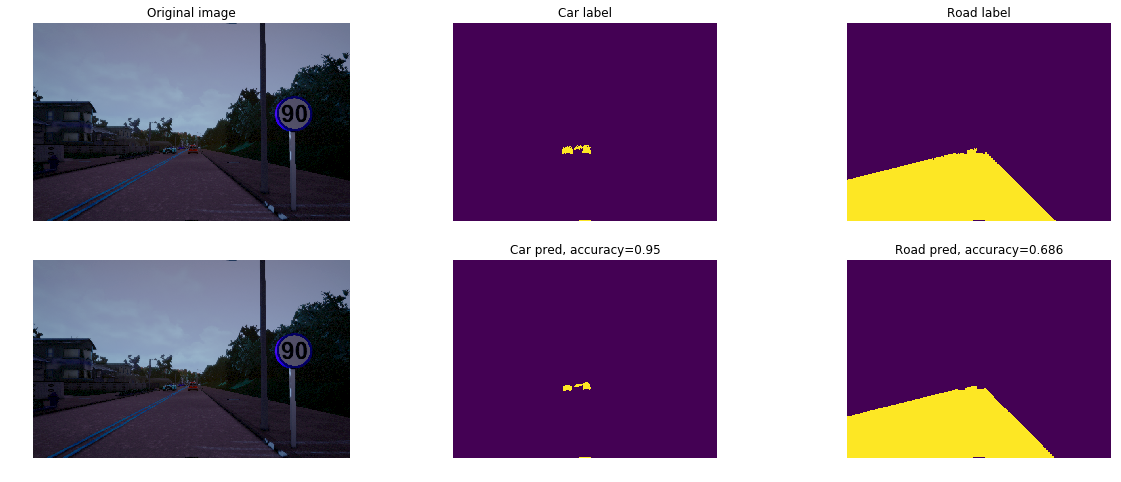

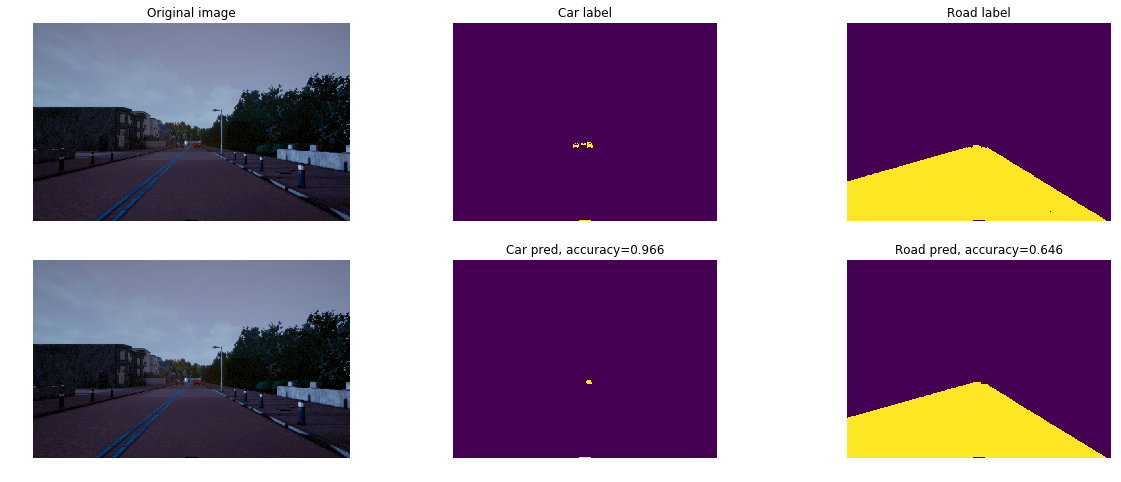

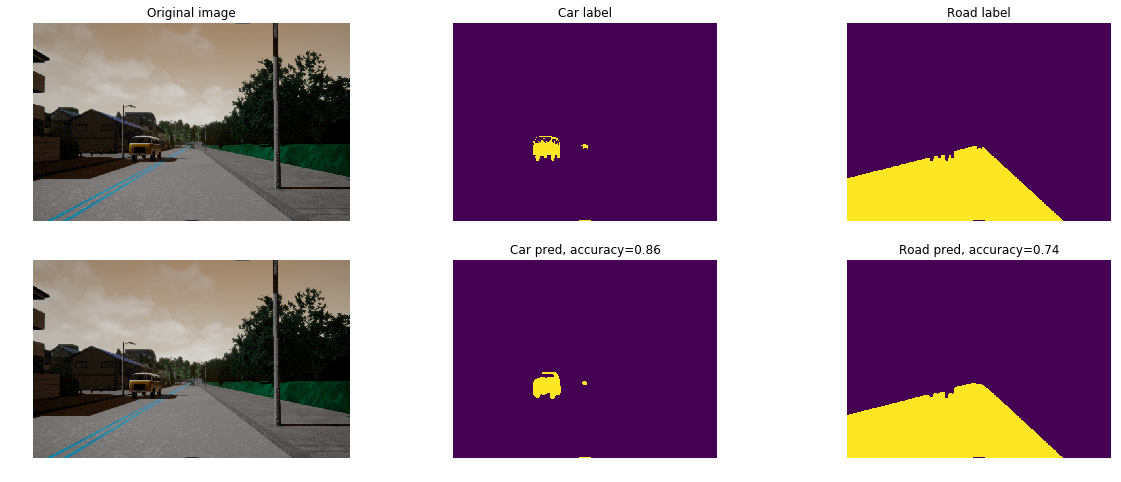

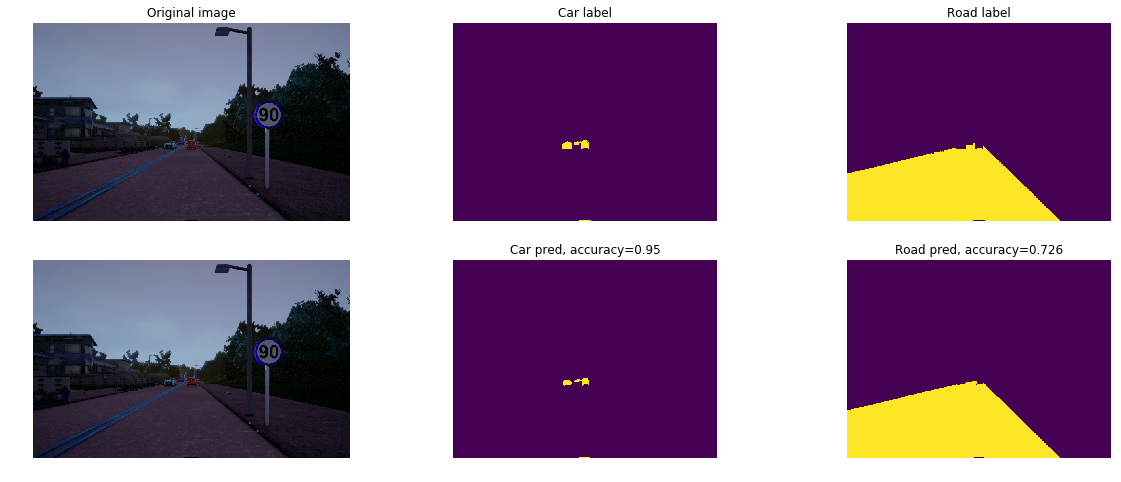

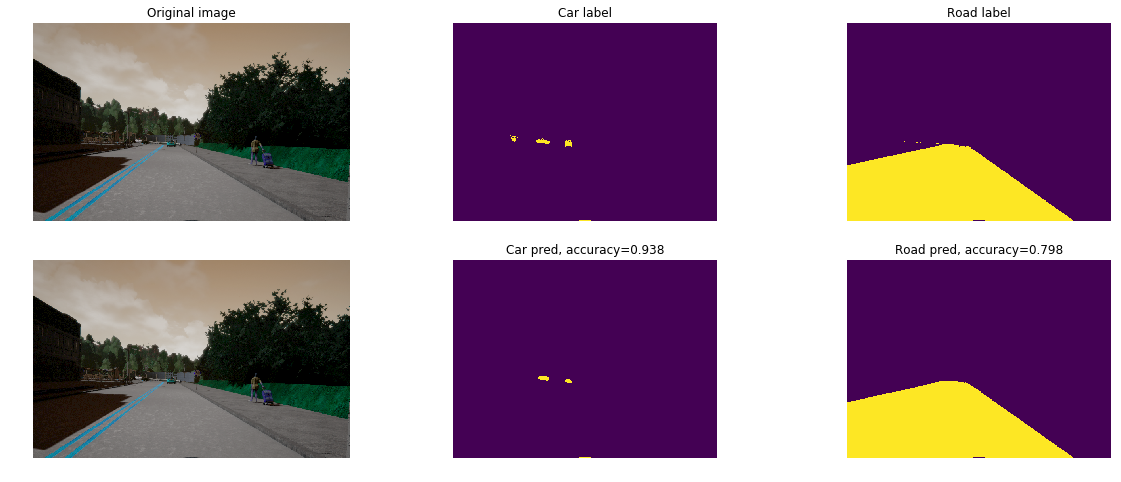

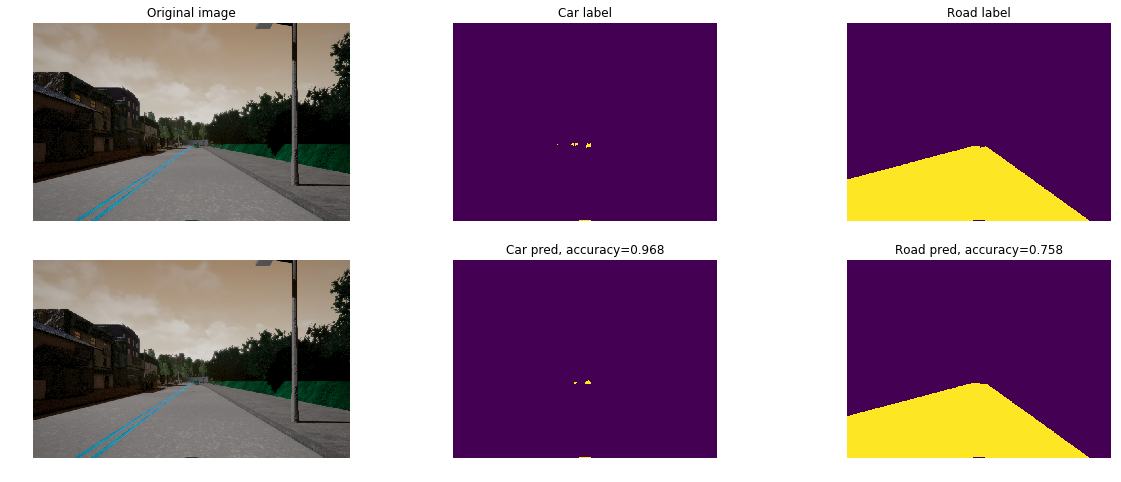

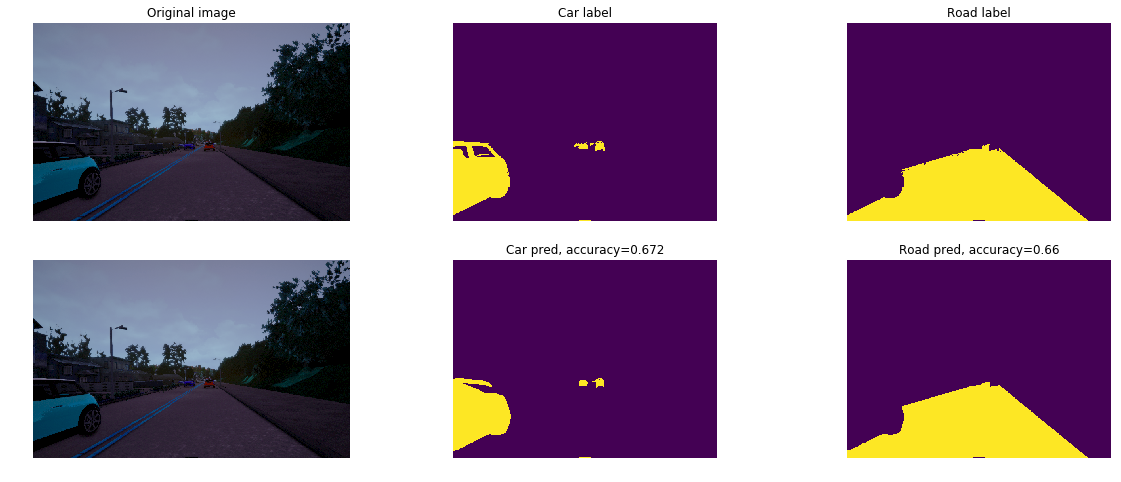

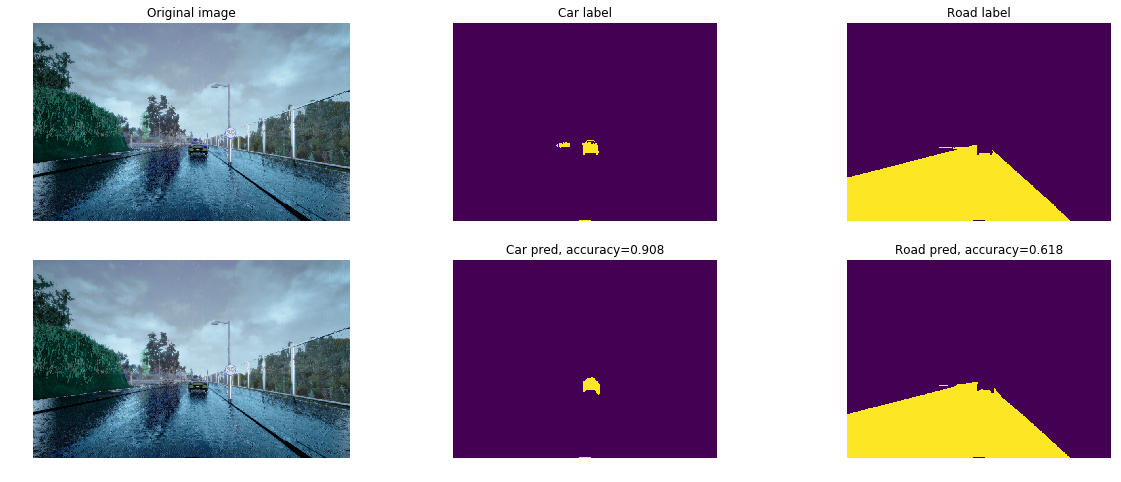

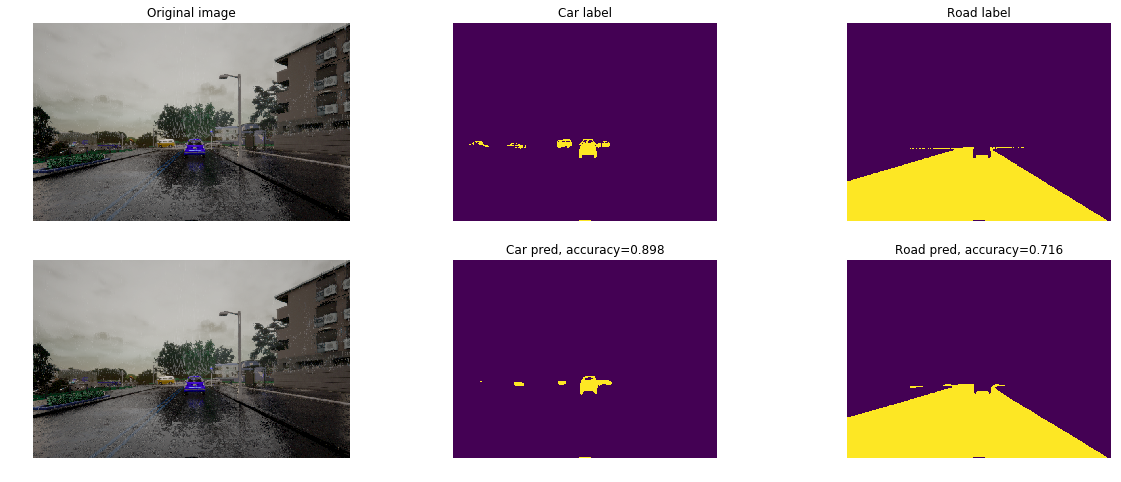

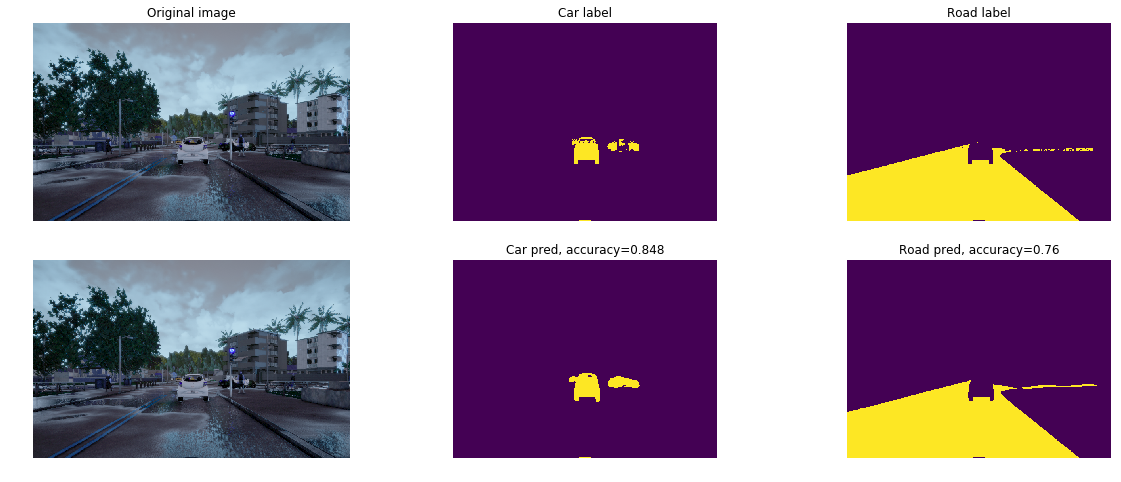

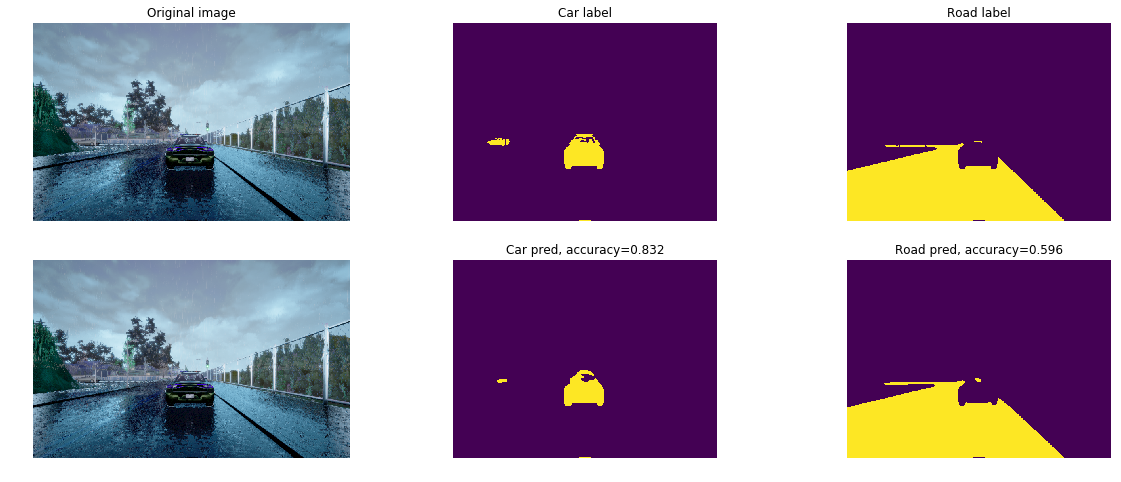

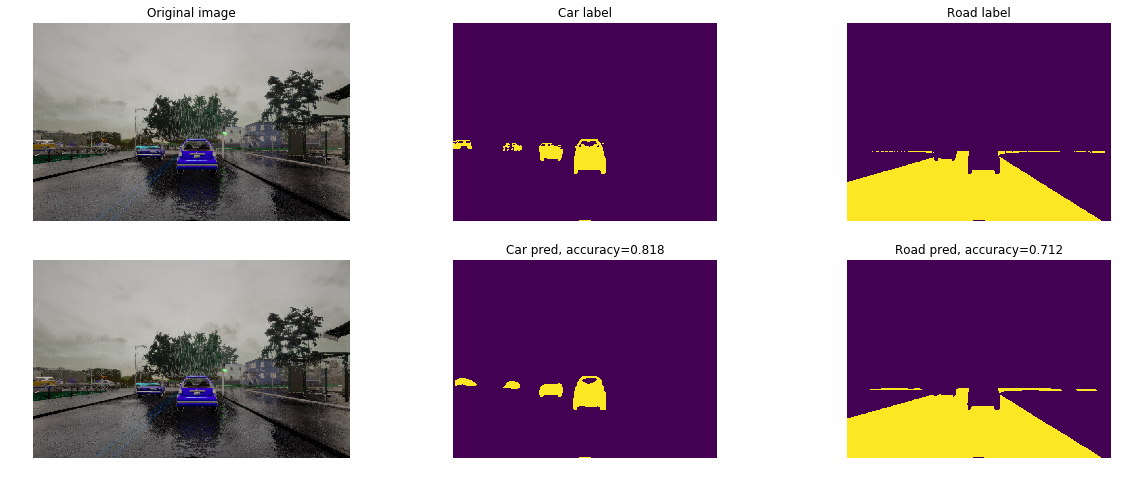

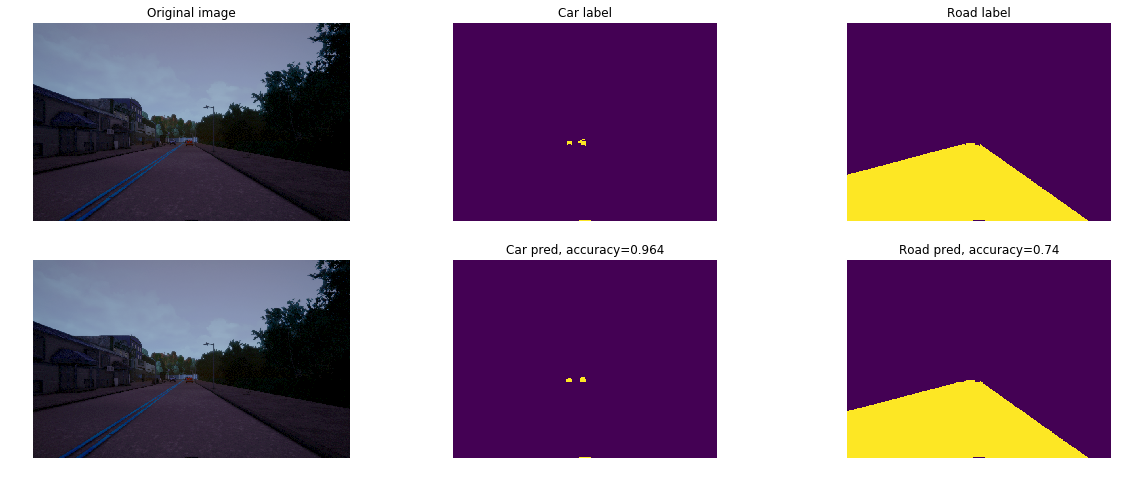

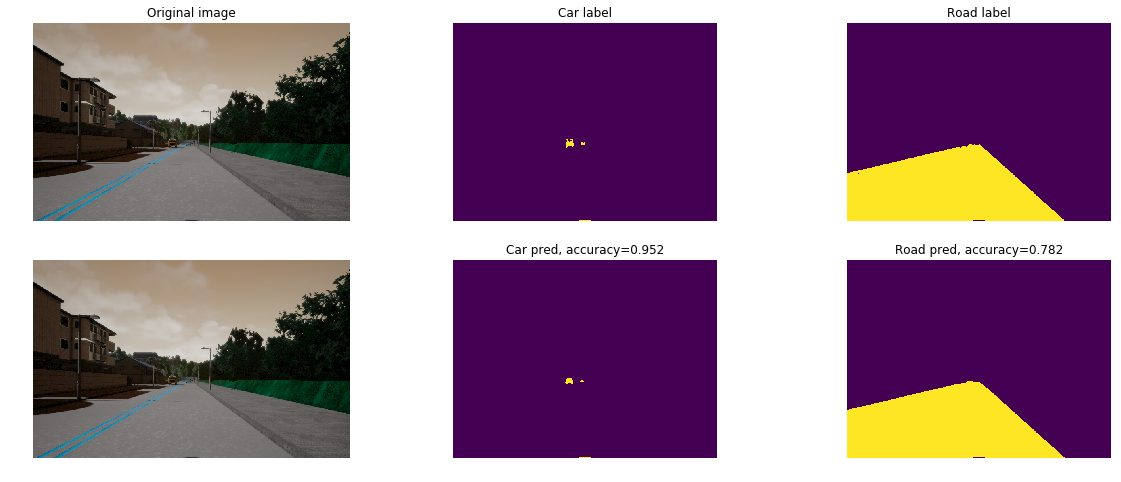

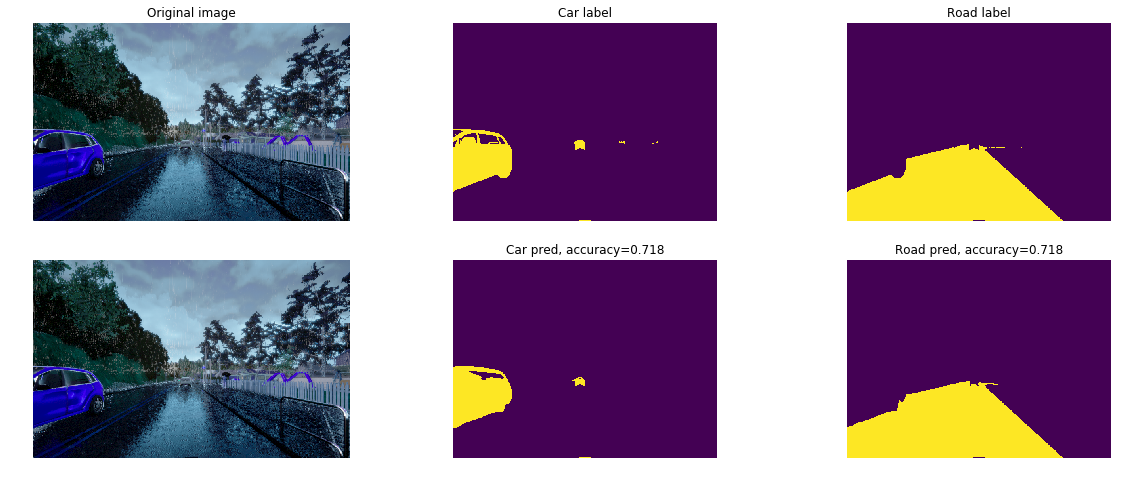

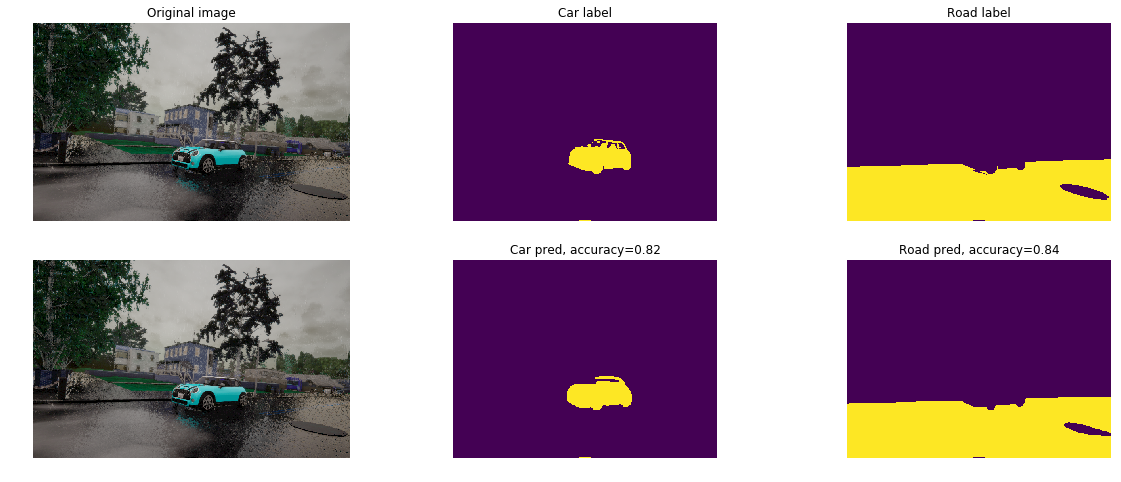

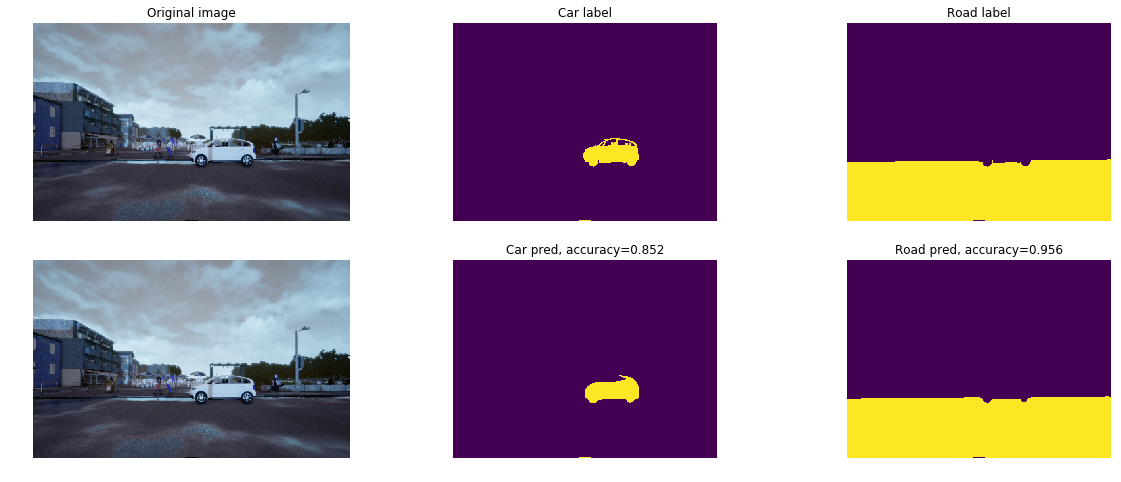

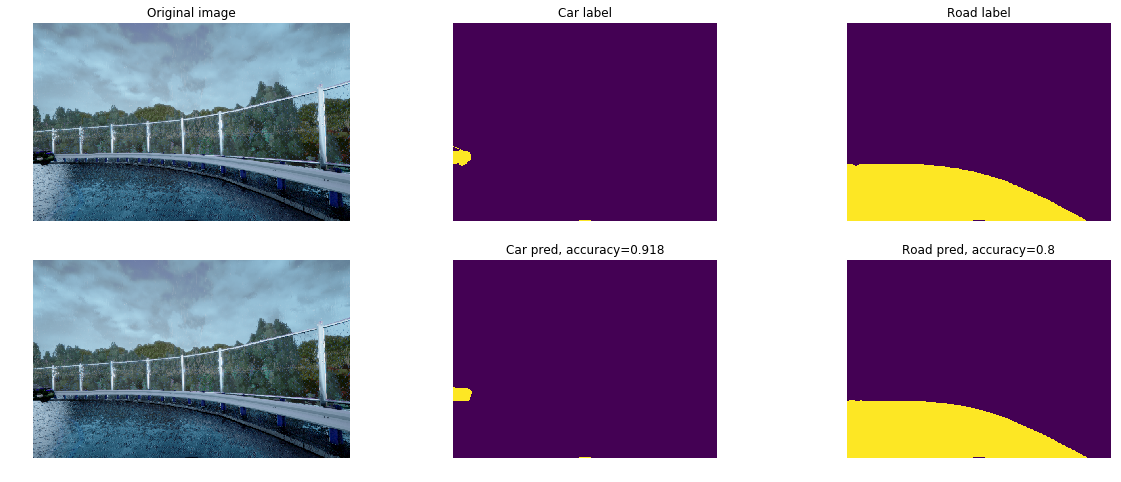

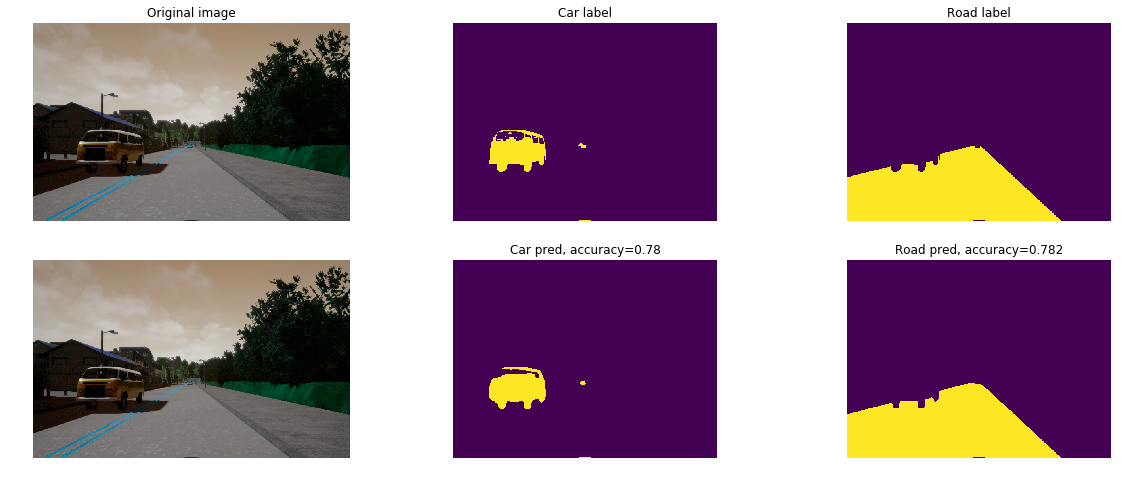

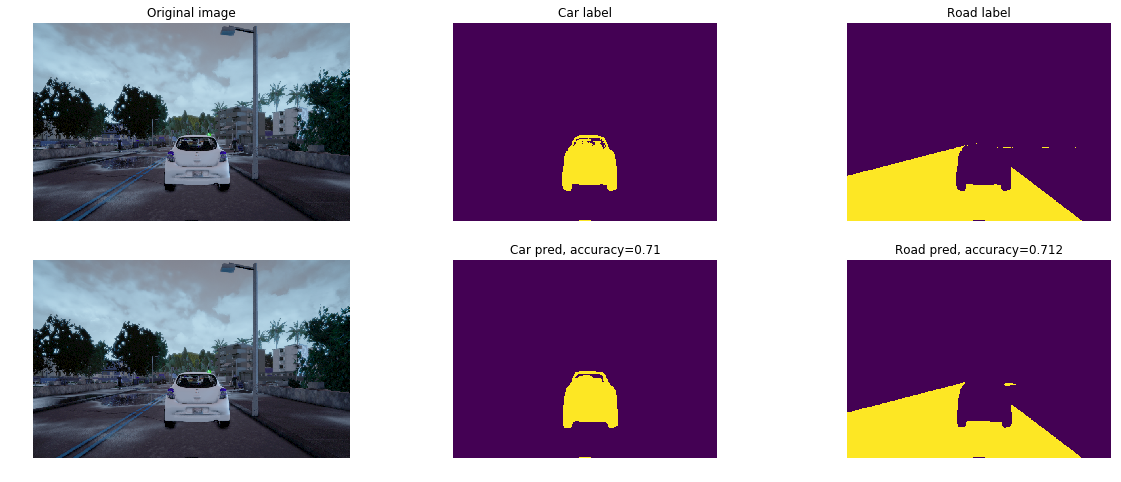

In [38]:
for i in range(len(test_samples)):
    test_img  = cv2.imread(test_samples.iloc[i]['image'])[:500,:,:]
    test_lbl  = cv2.imread(test_samples.iloc[i]['label'])[:,:,2]
    test_lbl = test_lbl[:500,:]
    test_lbl = cv2.resize(test_lbl, (666,500), interpolation = cv2.INTER_NEAREST)
    car_pred, road_pred = get_predictions(loaded_model, test_img)
    plot_results(test_img, test_lbl, car_pred, road_pred)

51~ ms. Since my GPU is roughly equal to Tesla K80, this must run at 20~ FPS.